Team Members:</br>
1. Piyush Gautam (pg2374)</br>
2. Jayanth Guduru (jg7162)</br>
3. Naveen Mallemala (nm3937)</br>

GitHub : https://github.com/pg2374/Pytorch-CIFAR10-RESNET18

#Pytorch on CIFAR-10 Dataset with Batch Normalisation and Dropout on Convolution Layers output after the activation function 

In [2]:
# Install torchvision
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.5 kB/s 
     |████████████████████████████████| 8.8 MB 89.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0+cu92 which 

In [3]:
'''ResNet in PyTorch.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition.
[2] https://github.com/kuangliu/pytorch-cifar
[3] https://github.com/abhisikdar/RESNET18-CIFAR10 
[4] https://www.srose.biz/wp-content/uploads/2020/08/Batch-Size-and-Epochs.html  
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        # Dropout after Convolutional BasicBlock
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.dropout = nn.Dropout(0.25)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [ ]:
# # Calculating the top 1% accuracy
# def accuracy(output: torch.Tensor, target: torch.Tensor, topk=(1,)):
#     with torch.no_grad():
#         maxk = max(topk) 
#         batch_size = target.size(0)
#         _, y_pred = output.topk(k=maxk, dim=1) 
#         y_pred = y_pred.t()
#         target_reshaped = target.view(1, -1).expand_as(y_pred)
#         correct = (y_pred == target_reshaped)

#         list_topk_accs = []
#         for k in topk:
#             ind_which_topk_matched_truth = correct[:k]
#             flattened_indicator_which_topk_matched_truth = ind_which_topk_matched_truth.reshape(-1).float()
#             tot_correct_topk = flattened_indicator_which_topk_matched_truth.float().sum(dim=0, keepdim=True)
#             topk_acc = tot_correct_topk / batch_size 
#             list_topk_accs.append(topk_acc)
#         return list_topk_accs


In [4]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.backends.cudnn as cudnn

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.2.0+cu92 CUDA 9.2.148
Device: cuda:0


# Data Pre-processing</br>
1. Random cropping, with size 32x32 and padding 4</br>
2. Random horizontal flipping with a probability of 0.5</br>
3. Normalize each image’s RGB channel with mean() and std()</br>

In [5]:
data_path='../data/'
cifar=datasets.CIFAR10(data_path, train= True, download=True, transform=transforms.ToTensor())
cifar_val=datasets.CIFAR10(data_path, train=False, download= True, transform=transforms.ToTensor())

170500096it [00:11, 14509573.04it/s]                               


Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [6]:
cifar_stack = torch.stack([img for img, _ in cifar], dim=3)
print('Shape of the CIFAR stack is',cifar_stack.shape)
mean= cifar_stack.view(3,-1).mean(dim=1)
std= cifar_stack.view(3,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)

Shape of the CIFAR stack is torch.Size([3, 32, 32, 50000])
Mean of training data is tensor([0.4915, 0.4823, 0.4468])
Standard deviation of training data is tensor([0.2470, 0.2435, 0.2616])


In [7]:
cifar_transformed = datasets.CIFAR10(data_path,train=True,download=False, transform=transforms.Compose([
                                                                                                      transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean,std)
]))
cifar_val_transformed = datasets.CIFAR10(data_path,train=False,download=False, transform=transforms.Compose([
                                                                                                      transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean,std)
]))

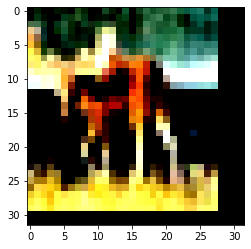

In [8]:
# View images

img, label = cifar_transformed[28]
plt.imshow(img.permute(1, 2, 0))    
plt.show()

#Varied the batch size for training dataset with other parameters fixed to measure the effect of batch size.</br>
Now, our Data is ready for Training.</br>


In [ ]:
# Parameters
batch_size=[256,512]
val_batch_size=100
num_epochs=80
# learning_rate=0.1

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

Epoch no 1:	 Train Loss: 2.059316 	 Train Accuracy: 0.407820 	 Validation Accuracy: 0.410500


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch no 2:	 Train Loss: 1.409685 	 Train Accuracy: 0.491840 	 Validation Accuracy: 0.483800
Epoch no 3:	 Train Loss: 1.353077 	 Train Accuracy: 0.567820 	 Validation Accuracy: 0.558500
Epoch no 4:	 Train Loss: 1.023971 	 Train Accuracy: 0.640840 	 Validation Accuracy: 0.626000
Epoch no 5:	 Train Loss: 0.733464 	 Train Accuracy: 0.687800 	 Validation Accuracy: 0.679900
Epoch no 6:	 Train Loss: 0.746233 	 Train Accuracy: 0.706020 	 Validation Accuracy: 0.691300
Epoch no 7:	 Train Loss: 0.760231 	 Train Accuracy: 0.760340 	 Validation Accuracy: 0.742000
Epoch no 8:	 Train Loss: 0.619271 	 Train Accuracy: 0.784280 	 Validation Accuracy: 0.764100
Epoch no 9:	 Train Loss: 0.762107 	 Train Accuracy: 0.788940 	 Validation Accuracy: 0.772600
Epoch no 10:	 Train Loss: 0.454060 	 Train Accuracy: 0.811220 	 Validation Accuracy: 0.789900
Epoch no 11:	 Train Loss: 0.462879 	 Train Accuracy: 0.819220 	 Validation Accuracy: 0.798700
Epoch no 12:	 Train Loss: 0.415925 	 Train Accuracy: 0.831320 	 Vali

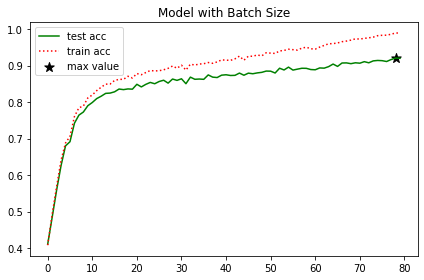

Epoch no 1:	 Train Loss: 1.851783 	 Train Accuracy: 0.254240 	 Validation Accuracy: 0.256800
Epoch no 2:	 Train Loss: 1.632281 	 Train Accuracy: 0.382580 	 Validation Accuracy: 0.389900
Epoch no 3:	 Train Loss: 1.505038 	 Train Accuracy: 0.465100 	 Validation Accuracy: 0.470600
Epoch no 4:	 Train Loss: 1.293925 	 Train Accuracy: 0.563840 	 Validation Accuracy: 0.563800
Epoch no 5:	 Train Loss: 1.042036 	 Train Accuracy: 0.623260 	 Validation Accuracy: 0.615700
Epoch no 6:	 Train Loss: 1.019472 	 Train Accuracy: 0.657540 	 Validation Accuracy: 0.647500
Epoch no 7:	 Train Loss: 0.872649 	 Train Accuracy: 0.674360 	 Validation Accuracy: 0.662700
Epoch no 8:	 Train Loss: 0.737331 	 Train Accuracy: 0.712220 	 Validation Accuracy: 0.699100
Epoch no 9:	 Train Loss: 0.681784 	 Train Accuracy: 0.737900 	 Validation Accuracy: 0.718600
Epoch no 10:	 Train Loss: 0.717634 	 Train Accuracy: 0.749120 	 Validation Accuracy: 0.735800
Epoch no 11:	 Train Loss: 0.684109 	 Train Accuracy: 0.778700 	 Valid

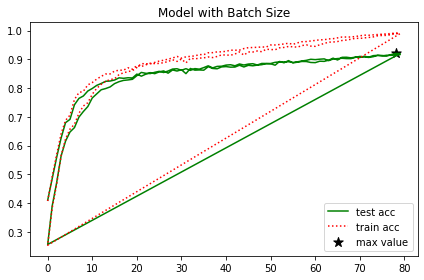

In [ ]:
for batch_no in range(len(batch_size)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size[batch_no],shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
        torch.save(resnet18,'./scratch.pt' )
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
      # print("Train Accuracy: ", correct_train_acc / total_train_acc)
      # print("Validation Accuracy: ", correct_val / total_val)
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with Batch Size")
  plt.legend()
  plt.tight_layout()
  plt.show()

#Varied the no of epochs with a fixed batch size to measure the effect of varying the epoch size.</br>



In [9]:
# Parameters
batch_size=512
val_batch_size=100
num_epochs=[80,100]
# learning_rate=2*1e-3

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

In [ ]:
for epoch_no in range(len(num_epochs)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs[epoch_no]):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with varying epochs")
  plt.legend()
  plt.tight_layout()
  plt.show()

Epoch no 1:	 Train Loss: 1.705435 	 Train Accuracy: 0.368280 	 Validation Accuracy: 0.368500
Epoch no 2:	 Train Loss: 1.373536 	 Train Accuracy: 0.441880 	 Validation Accuracy: 0.443300
Epoch no 3:	 Train Loss: 1.231500 	 Train Accuracy: 0.549800 	 Validation Accuracy: 0.547200
Epoch no 4:	 Train Loss: 1.127486 	 Train Accuracy: 0.625240 	 Validation Accuracy: 0.623000
Epoch no 5:	 Train Loss: 1.039310 	 Train Accuracy: 0.654880 	 Validation Accuracy: 0.647400
Epoch no 6:	 Train Loss: 0.864780 	 Train Accuracy: 0.692940 	 Validation Accuracy: 0.675700
Epoch no 7:	 Train Loss: 0.740361 	 Train Accuracy: 0.732340 	 Validation Accuracy: 0.716100
Epoch no 8:	 Train Loss: 0.689303 	 Train Accuracy: 0.763980 	 Validation Accuracy: 0.749300
Epoch no 9:	 Train Loss: 0.659299 	 Train Accuracy: 0.782020 	 Validation Accuracy: 0.762100
Epoch no 10:	 Train Loss: 0.543191 	 Train Accuracy: 0.798360 	 Validation Accuracy: 0.783500
Epoch no 11:	 Train Loss: 0.488325 	 Train Accuracy: 0.816760 	 Valid

#Varied the learning rate [0.1, 0.01, 0.001, 0.0001] on fixed batch size and fixed no of epoch to observe the effect of varying the epoch size</br>
Results for lr = 0.1 have been shown above  

In [ ]:
# Parameters
batch_size=512
val_batch_size=100
num_epochs=100
learning_rate=[0.01, 0.001, 0.0001]

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

In [ ]:
for lr_no in range(len(learning_rate)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate[lr_no], momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with varying learning rate")
  plt.legend()
  plt.tight_layout()
  plt.show()

Epoch no 1:	 Train Loss: 1.551991 	 Train Accuracy: 0.448880 	 Validation Accuracy: 0.446100
Epoch no 2:	 Train Loss: 1.250871 	 Train Accuracy: 0.557820 	 Validation Accuracy: 0.548600
Epoch no 3:	 Train Loss: 1.069364 	 Train Accuracy: 0.621800 	 Validation Accuracy: 0.615400
Epoch no 4:	 Train Loss: 0.962515 	 Train Accuracy: 0.662900 	 Validation Accuracy: 0.649600
Epoch no 5:	 Train Loss: 0.826966 	 Train Accuracy: 0.691100 	 Validation Accuracy: 0.671400
Epoch no 6:	 Train Loss: 0.749300 	 Train Accuracy: 0.722660 	 Validation Accuracy: 0.710500
Epoch no 7:	 Train Loss: 0.782519 	 Train Accuracy: 0.751580 	 Validation Accuracy: 0.735600
Epoch no 8:	 Train Loss: 0.733328 	 Train Accuracy: 0.770500 	 Validation Accuracy: 0.753200
Epoch no 9:	 Train Loss: 0.567519 	 Train Accuracy: 0.789820 	 Validation Accuracy: 0.771700
Epoch no 10:	 Train Loss: 0.514912 	 Train Accuracy: 0.798120 	 Validation Accuracy: 0.781700
Epoch no 11:	 Train Loss: 0.592834 	 Train Accuracy: 0.809020 	 Valid

#Changed the optimizer and loss function to HingeEmbeddingLoss with rest values fixed to observe the effect of varying the optimizer and loss function.</br>

In [ ]:
# Parameters
batch_size=512
val_batch_size=100
num_epochs=80
# learning_rate=2*1e-3

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

In [ ]:
# Train/Test Data
train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

# Model
resnet18 =ResNet18()
resnet18=resnet18.to(dev)
loss_func= torch.nn.HingeEmbeddingLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

for i in range(num_epochs):
  # Training
  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= resnet18(imgs)
    loss=loss_func(out,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0
  # Testing
  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = resnet18(imgs) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    val_acc.append(correct_val/total_val)

  # Compute Loss and Accuracy on training data
    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=resnet18(train_acc_imgs)
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
      # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
      # print("Top-1 training accuracy for minibatch", minibatch_acc)
    train_acc.append(correct_train_acc/total_train_acc)
    
    
    if correct_val/total_val > max_validation:
      max_validation=correct_val/total_val
      max_epoch=i
  epochs.append(i)

  

  if i%1==0:
    print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
  
  scheduler.step()

print(max_validation)

# Plot Train Accuracy vs Test Accuracy
plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
plt.title("Model with different optimizer and loss function")
plt.legend()
plt.tight_layout()
plt.show()